In [2]:
import pickle
import numpy as np
import ase.io
from ase.io import extxyz
from ase.build import fcc100, add_adsorbate, molecule
from ase import Atoms
from ase.calculators.emt import EMT
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
import os

import ase.io
from ase.build import bulk
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.calculators.emt import EMT
from ase.optimize import BFGS
import matplotlib.pyplot as plt
import lmdb
import pickle
from tqdm import tqdm
import torch
import os
from pymatgen.core.composition import Composition
from ocpmodels.preprocessing import AtomsToGraphs
from ocpmodels.datasets import SinglePointLmdbDataset, TrajectoryLmdbDataset
dic_ads = pickle.load(open('/Users/rimassouel/Documents/ocp/explo/mapping_adslab_slab.pkl','rb'))
dic_data = pickle.load(open('/Users/rimassouel/Documents/ocp/explo/oc20_data_mapping.pkl','rb'))


In [3]:
def filter_comp(COMP, CATA, uniques):
    here = True
    filtered = []
    for cata, comp in zip(CATA,COMP) :
        for elem in comp :
              if elem not in uniques :
                     here = False


        if here : 
            filtered.append(cata)
            
        here = True
  
    return filtered

def parse_comp(COMP, uniques) :
        dic = {}
        total = 0
        here = True
        for cata in COMP :
            for elem in cata :
                if elem not in uniques :
                    here = False
    
                    if elem in dic : dic[elem] +=1
                    else : dic[elem] = 1
            if not here : total+=1
            here = True
    
    
    
        return dic, total
def get_element_distribution_all(COMP):
    count_ = {}
    for cata in COMP :
          for elem in cata :
                    if elem in count_:
        
                        count_[elem] +=1
                    else : count_[elem] = 1
                  
    return count_





# Catalysts type and composition parsing


In [4]:
system_paths = os.listdir('/Users/rimassouel/Documents/ocp/explo/h20/data/') # path to uncompressed H20 trajectories files
idx = 0
UNARY = []
UNARY_file = []
BINARY = []
BINARY_file = []
BINARY_COMP = []
TERNARY = []
TERNARY_COMP = []
TERNARY_file = []
 
for system in system_paths:
     # Extract Data object
 
 
    id = system.replace('.traj', '')
    ads = dic_data[id]['ads_symbols']
    cata_raw = dic_data[id]['bulk_symbols']
 
    comp = Composition(cata_raw)
    formula = (comp.formula).split(' ')
    for j in range(len(formula)) :
         formula[j] = ''.join([i for i in formula[j] if not i.isdigit()])
 
 
    reduced = result = ''.join([i for i in comp.reduced_formula if not i.isdigit()])
 
    if len(formula) ==1 :
        UNARY.append(reduced)
        UNARY_file.append(system)
    elif len(formula) == 2 :
        BINARY.append(reduced)
        BINARY_COMP.append(formula)
        BINARY_file.append(system)
    elif len(formula) == 3 :
        TERNARY.append(reduced)
        TERNARY_COMP.append(formula)  
        TERNARY_file.append(system)


In [5]:
uniques, counts = np.unique(UNARY, return_counts = True)
UNIQUES = uniques
COUNTS = counts

print('Number of trajectories with unary catalyts '+str(len(UNARY)))
print('Unique number of unary catalyts : '+str(len(uniques)))

uniques, counts = np.unique(TERNARY, return_counts = True)
 
print('Number of trajectories with ternary catalyts '+str(len(TERNARY)))
print('Unique number of ternary catalyts :'+str(len(uniques)))
uniques, counts = np.unique(BINARY, return_counts = True)
 
print('Number of trajectories with binary catalyts '+str(len(BINARY)))
print('Unique number of binary catalyts :'+str(len(uniques)))

Number of trajectories with unary catalyts 436
Unique number of unary catalyts : 46
Number of trajectories with ternary catalyts 2625
Unique number of ternary catalyts :1735
Number of trajectories with binary catalyts 4975
Unique number of binary catalyts :719


# Unary catalysts distribution

<BarContainer object of 46 artists>

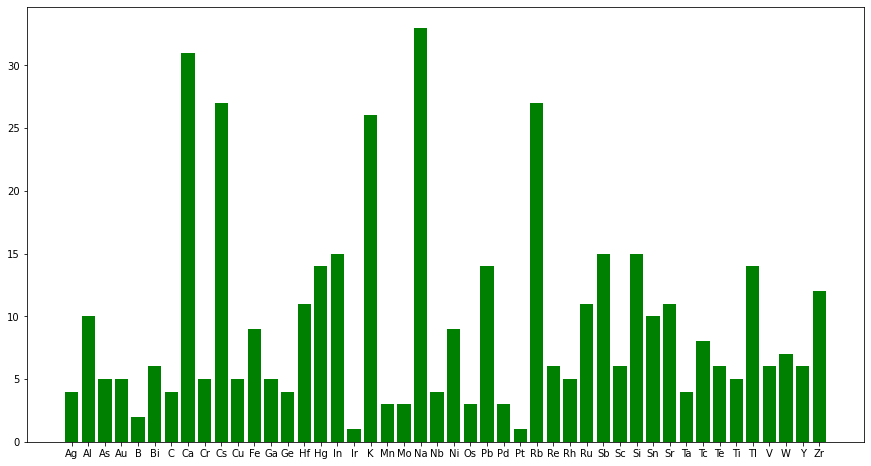

In [6]:
repet = {}
for el, c in zip(UNIQUES, COUNTS):
     repet[el] = c
plt.figure(figsize=(15,8))
plt.bar([ str(i) for i in repet.keys()], repet.values(), color='g')




# Composite Catalysts representation - ALL

Text(0.5, 1.0, 'elements distributions in all binary catalysts')

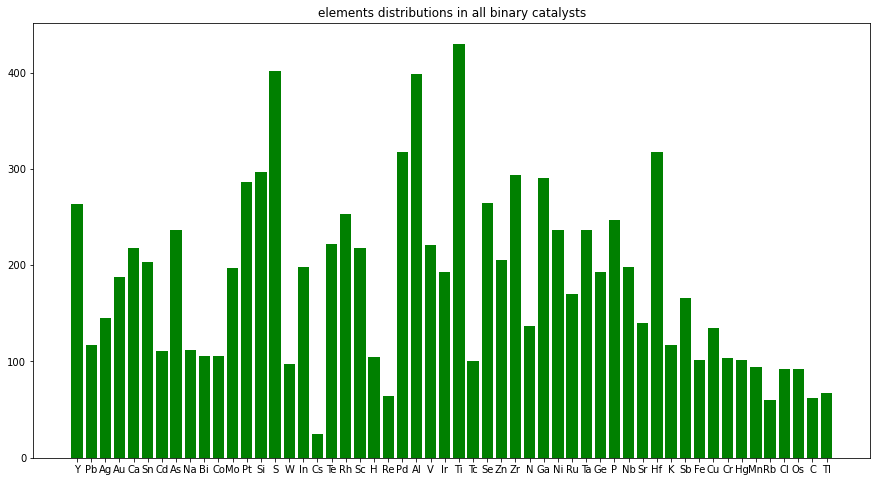

In [7]:
dic_bin = get_element_distribution_all(BINARY_COMP)
plt.figure(figsize=(15,8))
plt.bar([ str(i) for i in dic_bin.keys()], dic_bin.values(), color='g')
plt.title('elements distributions in all binary catalysts')

Text(0.5, 1.0, 'elements distributions in all ternary catalysts')

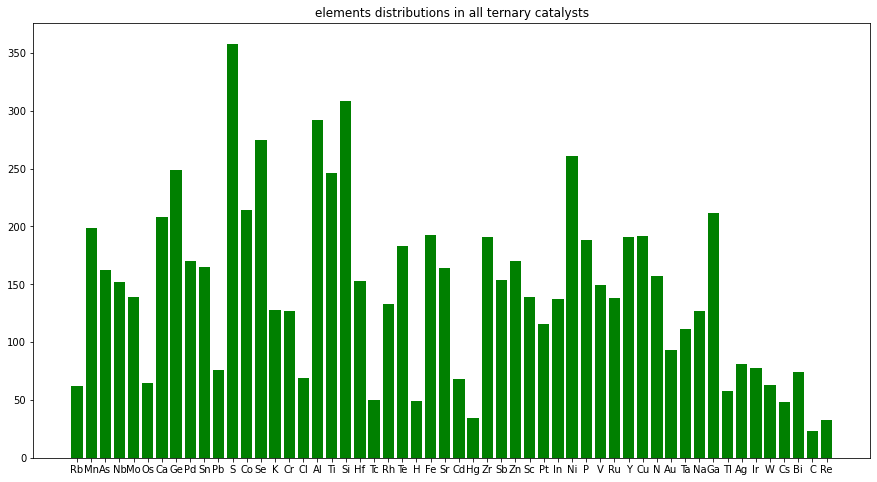

In [8]:
dic_tern = get_element_distribution_all(TERNARY_COMP)
plt.figure(figsize=(15,8))
plt.bar([ str(i) for i in dic_tern.keys()], dic_tern.values(), color='g')
plt.title('elements distributions in all ternary catalysts')


# Composite Catalysts representation - REPRESENTED ONLY

In [9]:
count = {}
for el in UNIQUES:
     count[el] = 0
def get_element_distribution_rep(COMP):
    count_ = count.copy()
    for cata in COMP :
          for elem in cata :
                    if elem in count_:
        
                        count_[elem] +=1
                  
    return count_

Text(0.5, 1.0, 'represented binary catalysts elements distribution')

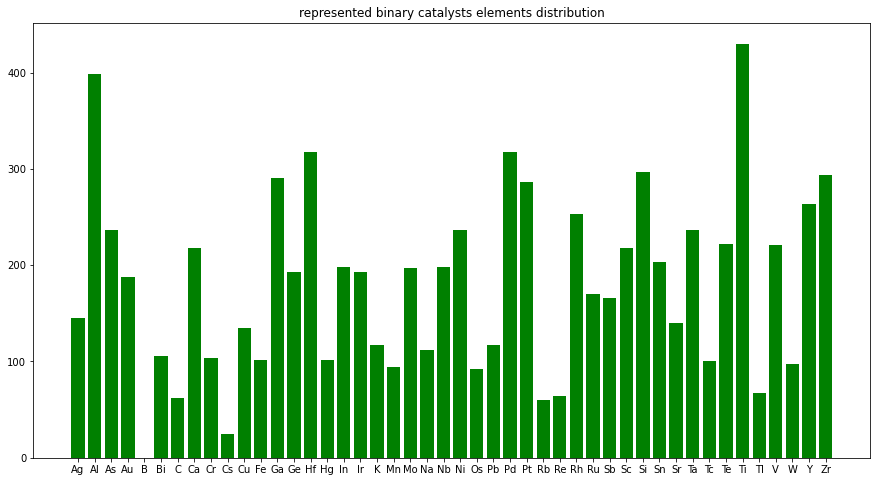

In [10]:
dic_bin_filter = get_element_distribution_rep(BINARY_COMP)
plt.figure(figsize=(15,8))
plt.bar([ str(i) for i in dic_bin_filter.keys()], dic_bin_filter.values(), color='g')
plt.title('represented binary catalysts elements distribution')


Text(0.5, 1.0, 'represented tenary catalysts elements distribution')

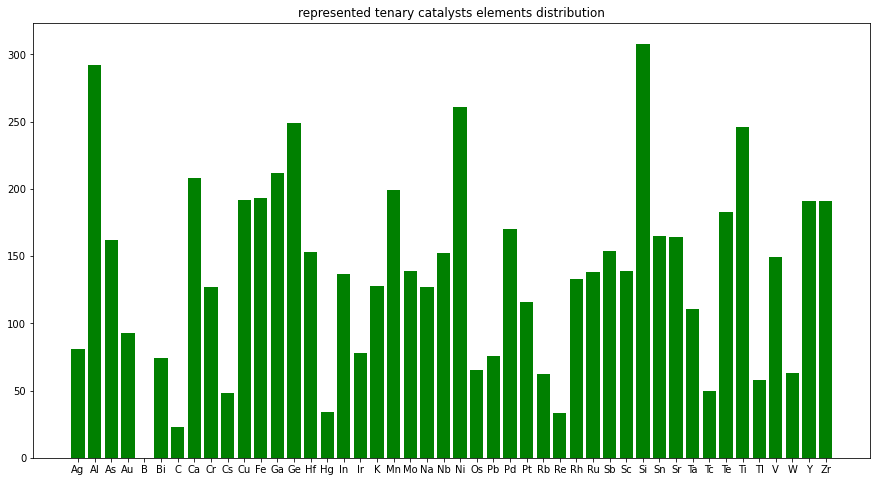

In [11]:
dic_tern_filter = get_element_distribution_rep(TERNARY_COMP)
plt.figure(figsize=(15,8))
plt.bar([ str(i) for i in dic_tern_filter.keys()], dic_tern_filter.values(), color='g')
plt.title('represented tenary catalysts elements distribution')



## Non-represented elements in binary/ternary catalysts

Text(0.5, 1.0, 'non represented elemnts in ternary catalysts')

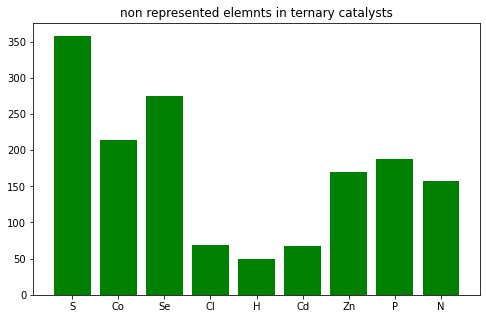

In [12]:
ne_tern, total_tern = parse_comp(TERNARY_COMP, UNIQUES)
tot = len(TERNARY_COMP)
plt.figure(figsize=(8,5))
plt.bar([ str(i) for i in ne_tern.keys()], ne_tern.values(), color='g')
plt.title('non represented elemnts in ternary catalysts')



Text(0.5, 1.0, 'non represented elemnts in binary catalysts ')

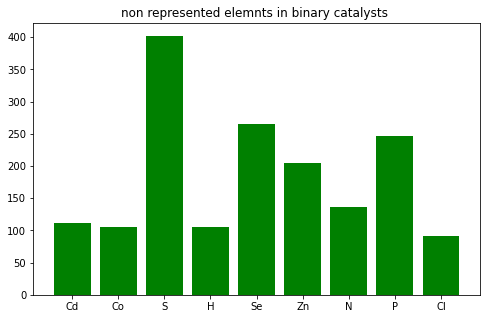

In [13]:
ne_bin, total_bin = parse_comp(BINARY_COMP, UNIQUES)
tot = len(BINARY_COMP)
plt.figure(figsize=(8,5))
plt.bar([ str(i) for i in ne_bin.keys()], ne_bin.values(), color='g')
plt.title('non represented elemnts in binary catalysts ')



# Splits definition

In [14]:
def filter_files_represented(COMP, FILES):
        new_files = []
    
        here = True
        for cata, file in zip(COMP, FILES) :
            for elem in cata :
                
                if elem not in UNIQUES :
                    here = False     
            if here :  new_files.append(file)
            here = True
        return new_files
    

In [15]:
REP_BIN = filter_files_represented(BINARY_COMP, BINARY_file)
REP_TER = filter_files_represented(TERNARY_COMP, TERNARY_file)

In [16]:
print(len(REP_BIN))
print(len(REP_TER))
print(len(UNARY_file))

3380
1303
436


In [17]:
import random
def get_splits(unary, binary, ternary, val_ = 10, test_ = 20):
    train = []
    val = []
    test = []
    
    bin_len = len(binary)
    ter_len = len(ternary)
    
    val_num_bin = int((val_*bin_len/100))
    val_num_ter = int((val_*ter_len/100))
    
    test_num_bin = int((test_*bin_len/100))
    test_num_ter = int((test_*ter_len/100))
    
    
    train.extend(unary)
    
    
    random.shuffle(binary)
    random.shuffle(ternary)
    shuffled_bin = binary
    shuffled_ter = ternary
    
    bin_val = shuffled_bin[:val_num_bin]
    ter_val = shuffled_ter[:val_num_ter]
    
    bin_test = shuffled_bin[val_num_bin:val_num_bin + test_num_bin]
    ter_test = shuffled_ter[val_num_ter:val_num_ter + test_num_bin]
    
    bin_train = shuffled_bin[val_num_bin + test_num_bin:]
    ter_train = shuffled_ter[val_num_ter + test_num_ter:]
    
    train.extend(bin_train)
    train.extend(ter_train)
    val.extend(bin_val)
    val.extend(ter_val)
    test.extend(bin_test)
    test.extend(ter_test)
    
    return train, val,test
    
    


    
    

In [18]:
train, val, test = get_splits(UNARY_file, REP_BIN, REP_TER)

In [19]:
print(len(train))
print(len(val))
print(len(test))

3715
468
1352


In [20]:
with open('train_files.txt', 'w') as f:
    for item in train:
        f.write("%s\n" % item)
    f.close()
    
with open('val_files.txt', 'w') as f:
    for item in val:
        f.write("%s\n" % item)
    f.close()
with open('test_files.txt', 'w') as f:
    for item in test:
        f.write("%s\n" % item)
    f.close()

In [24]:
for item in val : 
    if not os.path.isfile('/Users/rimassouel/Documents/ocp/explo/h20/data/'+item) : 
        print(item)
for item in test : 
    if not os.path.isfile('/Users/rimassouel/Documents/ocp/explo/h20/data/'+item) : 
        print(item)
for item in train : 
    if not os.path.isfile('/Users/rimassouel/Documents/ocp/explo/h20/data/'+item) : 
        print(item)